# Convert keras to tflite and benchmark models

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Github
%cd 'LacmusTflite'

In [2]:
!pip install pandas

     |████████████████████████████████| 11.7 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 2.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd

saved_model_dir = 'snapshots/B0/'
FP32_TFLITE  = 'fp32_model.tflite'
FP16_TFLITE  = 'fp16_model.tflite'
INT8_TFLITE  = 'int8_model.tflite'
UINT8_TFLITE = 'uint8_model.tflite'
INT16_TFLITE = 'int16_model.tflite'

## Prepare data for benchmarking

In [5]:
B = 0
DATA_DIR = 'LizaAlertDroneDatasetV4_Winter'
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['__pycache__',
 'ImageSets',
 'Annotations',
 'JPEGImages',
 'crops1024',
 '.ipynb_checkpoints']

In [6]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE, DATA_DIR)
        for o in out:
            _, x, y, _ = o
            yield x, y

N_samples = len(list(test_gen()))

In [7]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).shuffle(BATCH_SIZE*4).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [8]:
it = iter(test_gen())

In [9]:
sample = next(it)
x, y = sample
x.shape, y.shape

((224, 224, 3), (7, 7))

In [10]:
def show_img(x, y):
    plt.figure(figsize=(8,8))

    img = tf.keras.utils.array_to_img(x)
    xy = np.array(np.where(y==1)).ravel()[::-1]
    bb = np.array([xy, xy+1]).ravel() * 32

    draw = ImageDraw.Draw(img)
    draw.rectangle(bb.tolist(), outline=(200,0,0))
    y_img = Image.fromarray(y*255)
    y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))


    plt.imshow(img)
    plt.show()  

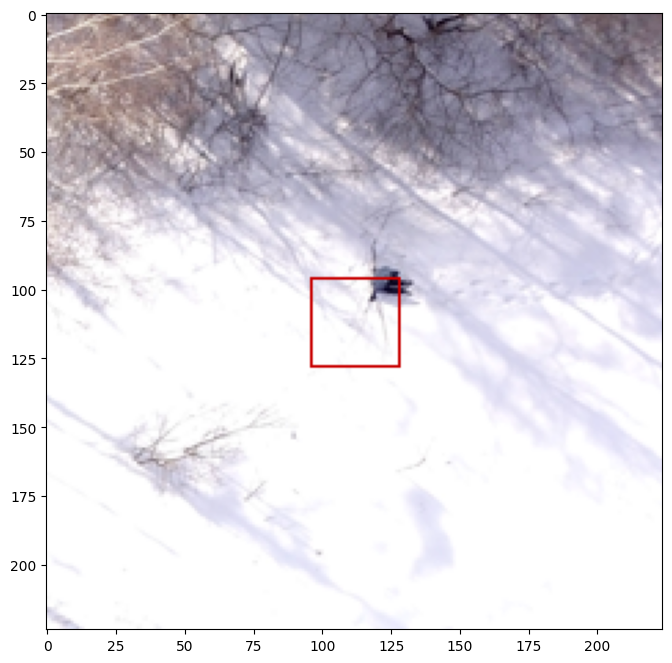

In [11]:
show_img(x,y)

## Benchmark keras model

In [12]:
model = tf.keras.models.load_model(saved_model_dir, compile=False )

In [13]:
%%time
# First time too long
pred=model(np.expand_dims(x, 0))

CPU times: user 678 ms, sys: 30.5 ms, total: 708 ms
Wall time: 579 ms


In [14]:
%%timeit
pred=model(np.expand_dims(x, 0))

36.5 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
thresh=0.3

precision = tf.keras.metrics.Precision(thresholds=thresh)
recall = tf.keras.metrics.Recall(thresholds=thresh)

In [16]:
model.compile(metrics=[precision, recall])

In [17]:
%%time
loss,prec,rec = model.evaluate(test_dataset)

24/24 [==============================] - 14s 448ms/step - loss: 0.0000e+00 - precision: 0.6129 - recall: 0.9120
CPU times: user 37.2 s, sys: 3.05 s, total: 40.2 s
Wall time: 14 s


In [18]:
it = iter(test_dataset)
t = 0

for x_batch, y_batch in it:
    start = time.time()
    model.predict(x_batch)
    t += (time.time() - start)

ave_time = t / N_samples * 1000

In [19]:
print(f'time per image: {ave_time:.1f} ms')
print(f'Precision = {prec:.2f}, Recall =  {rec:.2f}')

time per image: 24.9 ms
Precision = 0.61, Recall =  0.91


In [20]:
keras_model_res=['Keras B0', ave_time, prec, rec]

## Benchmark tflite models 

### A helper functions to evaluate the TF Lite model using "test" dataset.

In [21]:
def predict_tflite_model(interpreter, test_images=test_gen):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    predictions = []
    test_labels=[]
    times = 0
    for test_image in test_gen():
        test_labels.append(test_image[1])
        test_image=test_image[0]
        test_image = np.expand_dims(test_image, axis=0).astype(np.uint8)

        start = time.time()
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_index)
        end = time.time()

        predictions.append(pred)
        times += (end - start)*1000
    predictions = np.array(predictions).reshape(-1, 7, 7)
    test_labels = np.array(test_labels)
    average_time = times / len(predictions)
    return predictions, test_labels, average_time

def evaluate_metrics(predictions, true_labels, tresh=0.3):
    predictions = (predictions >= tresh).ravel()
    true_labels = true_labels.ravel()
#     print (f'Total boxes: {len(predictions)}')
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')

    accuracy = (tp+tn)/(fp+fn+tp+tn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    return accuracy, precision, recall

### Benchmark fp32 tflite model with default optimization

In [22]:
# Convert the model
#converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp930x9_lo/assets


INFO:tensorflow:Assets written to: /tmp/tmp930x9_lo/assets


In [23]:
# Save the model.
with open(FP32_TFLITE, 'wb') as f:
    f.write(tflite_model)

In [24]:
interpreter = tf.lite.Interpreter(FP32_TFLITE)
interpreter.allocate_tensors()

In [25]:
# Get input and output tensors info
input_details = interpreter.get_input_details()[0]
input_details

{'name': 'serving_default_x:0',
 'index': 0,
 'shape': array([  1, 224, 224,   3], dtype=int32),
 'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [26]:
output_details = interpreter.get_output_details()[0]
output_details

{'name': 'StatefulPartitionedCall:0',
 'index': 517,
 'shape': array([1, 1, 1, 1], dtype=int32),
 'shape_signature': array([-1, -1, -1,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [27]:
print('input: ', input_details['dtype'])
print('output: ', output_details['dtype'])

input:  <class 'numpy.uint8'>
output:  <class 'numpy.float32'>


In [28]:
%%time
# Firts time is too long
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()

CPU times: user 751 ms, sys: 3.93 ms, total: 755 ms
Wall time: 767 ms


In [29]:
%%timeit
# assert that prediction times are already the same for random data and test data
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

723 ms ± 7.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
predictions, true_labels, average_time = predict_tflite_model(interpreter)
accuracy, precision, recall = evaluate_metrics(predictions, true_labels)
print(f'Average time = {average_time:.2f} ms, Precision = {precision:.2f}, Recall = {recall:.2f}')

TN = 8616, FP = 79, FN = 14, TP = 111
Average time = 731.95 ms, Precision = 0.58, Recall = 0.89


In [31]:
fp32_res = ['Tflite_fp32', average_time, precision, recall]

### Benchmark tflite model with fp16 optimization

In [32]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

In [33]:
# Save the model.
with open(FP16_TFLITE, 'wb') as f:
    f.write(tflite_model)

In [34]:
interpreter = tf.lite.Interpreter(FP16_TFLITE)
interpreter.allocate_tensors()

In [35]:
# Get input and output tensors info
input_details = interpreter.get_input_details()[0]
input_details

{'name': 'serving_default_input_1:0',
 'index': 0,
 'shape': array([  1, 224, 224,   3], dtype=int32),
 'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [36]:
output_details = interpreter.get_output_details()[0]
output_details

{'name': 'StatefulPartitionedCall:0',
 'index': 517,
 'shape': array([1, 1, 1, 1], dtype=int32),
 'shape_signature': array([-1, -1, -1,  1], dtype=int32),
 'dtype': numpy.float32,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [37]:
print('input: ', input_details['dtype'])
print('output: ', output_details['dtype'])

input:  <class 'numpy.uint8'>
output:  <class 'numpy.float32'>


In [38]:
%%time
# Firts time is too long
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

CPU times: user 154 ms, sys: 5.2 ms, total: 159 ms
Wall time: 99.1 ms


In [39]:
%%timeit
# assert that prediction times are already the same for random data and test data
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

63.7 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
predictions, true_labels, average_time = predict_tflite_model(interpreter)
accuracy, precision, recall = evaluate_metrics(predictions, true_labels)
print(f'Average time = {average_time:.2f} ms, Precision = {precision:.2f}, Recall = {recall:.2f}')

TN = 8623, FP = 72, FN = 10, TP = 115
Average time = 63.61 ms, Precision = 0.61, Recall = 0.92


In [41]:
fp16_res = ['Tflite_fp16', average_time, precision, recall]

## Benchmark int8 quantization

### Convert with uint8 quantization

In [42]:
def representative_dataset_uint8():
    for _ in range(8):
      data = np.random.rand(1, 224, 224, 3)
      yield [data.astype(np.uint8)]

In [43]:
int_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
int_converter.representative_dataset = representative_dataset_uint8
int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
int_converter.inference_input_type = tf.uint8  
int_converter.inference_output_type = tf.uint8  
tflite_quant_model = int_converter.convert()

In [44]:
with open(UINT8_TFLITE, 'wb') as f:
    f.write(tflite_quant_model)

In [45]:
interpreter = tf.lite.Interpreter(UINT8_TFLITE)
interpreter.allocate_tensors()

In [46]:
input_details = interpreter.get_input_details()[0]
input_details

{'name': 'serving_default_input_1:0',
 'index': 0,
 'shape': array([  1, 224, 224,   3], dtype=int32),
 'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [47]:
output_details = interpreter.get_output_details()[0]
output_details

{'name': 'StatefulPartitionedCall:0',
 'index': 519,
 'shape': array([1, 1, 1, 1], dtype=int32),
 'shape_signature': array([-1, -1, -1,  1], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.00390625, 0),
 'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
  'zero_points': array([0], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [48]:
print('input: ', input_details['dtype'])
print('output: ', output_details['dtype'])

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [49]:
%%time
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

CPU times: user 874 ms, sys: 0 ns, total: 874 ms
Wall time: 872 ms


1 15


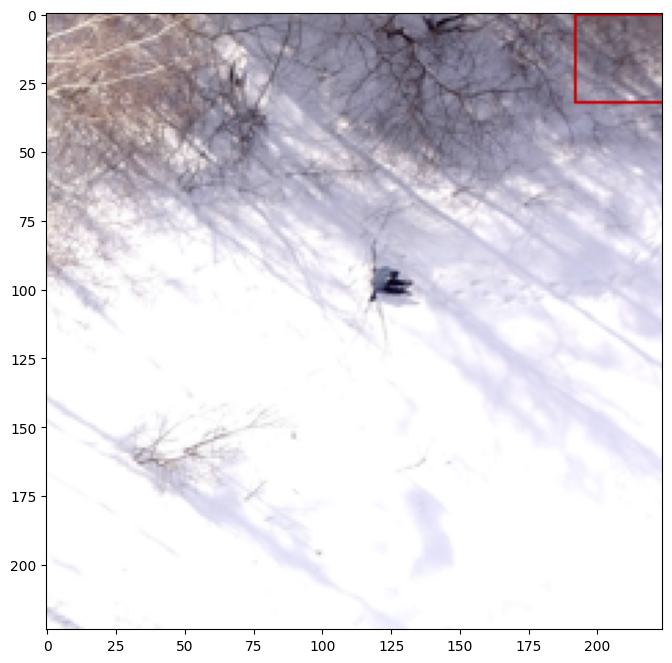

In [50]:
print(output_data.min(), output_data.max())
y_pred = output_data.reshape(7,7) == output_data.max()
show_img(x, y_pred.astype(np.uint8))

In [51]:
%%timeit
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

856 ms ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
# assert that prediction times are already the same for random data and test data
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

863 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
predictions, true_labels, average_time = predict_tflite_model(interpreter)

predictions = predictions / 255.
tresh = predictions.max() - 0.01

accuracy, precision, recall = evaluate_metrics(predictions, true_labels)
print(f'Average time = {average_time:.2f} ms, Precision = {precision:.2f}, Recall = {recall:.2f}')

TN = 8695, FP = 0, FN = 125, TP = 0
Average time = 858.59 ms, Precision = nan, Recall = 0.00


<ipython-input-21-6b442898567e>:35: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp/(tp+fp)


In [54]:
uint8_res = ['Tflite_uint8', average_time, precision, recall]

### Convert with int8 quantization

In [55]:
int_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
int_converter.representative_dataset = representative_dataset_uint8
int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
int_converter.inference_input_type = tf.uint8  
int_converter.inference_output_type = tf.int8  
tflite_quant_model = int_converter.convert()

In [56]:
with open(INT8_TFLITE, 'wb') as f:
    f.write(tflite_quant_model)

In [57]:
interpreter = tf.lite.Interpreter(INT8_TFLITE)
interpreter.allocate_tensors()

In [58]:
input_details = interpreter.get_input_details()[0]
input_details

{'name': 'serving_default_input_1:0',
 'index': 0,
 'shape': array([  1, 224, 224,   3], dtype=int32),
 'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
 'dtype': numpy.uint8,
 'quantization': (0.0, 0),
 'quantization_parameters': {'scales': array([], dtype=float32),
  'zero_points': array([], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [59]:
output_details = interpreter.get_output_details()[0]
output_details

{'name': 'StatefulPartitionedCall:0',
 'index': 518,
 'shape': array([1, 1, 1, 1], dtype=int32),
 'shape_signature': array([-1, -1, -1,  1], dtype=int32),
 'dtype': numpy.int8,
 'quantization': (0.00390625, -128),
 'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
  'zero_points': array([-128], dtype=int32),
  'quantized_dimension': 0},
 'sparsity_parameters': {}}

In [60]:
print('input: ', input_details['dtype'])
print('output: ', output_details['dtype'])

input:  <class 'numpy.uint8'>
output:  <class 'numpy.int8'>


In [61]:
%%time
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

CPU times: user 880 ms, sys: 33 µs, total: 880 ms
Wall time: 879 ms


In [62]:
%%timeit
# assert that prediction times are already the same for random data and test data
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

860 ms ± 5.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
predictions, true_labels, average_time = predict_tflite_model(interpreter)

predictions = predictions / 255. + 0.5
tresh = predictions.max() - 0.01

accuracy, precision, recall = evaluate_metrics(predictions, true_labels, tresh)
print(f'Average time = {average_time:.2f} ms, Precision = {precision:.2f}, Recall = {recall:.2f}')

TN = 8337, FP = 358, FN = 123, TP = 2
Average time = 854.27 ms, Precision = 0.01, Recall = 0.02


In [64]:
int8_res = ['Tflite_int8', average_time, precision, recall]

### Convert with int16 quantization

In [65]:
int_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
int_converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

int_converter.representative_dataset = representative_dataset_uint8
tflite_quant_model = int_converter.convert()

RuntimeError: Quantization to 16x8-bit not yet supported for op: 'CAST'.


In [ ]:
with open(INT16_TFLITE, 'wb') as f:
    f.write(tflite_quant_model)

In [ ]:
interpreter = tf.lite.Interpreter(INT16_TFLITE)
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()[0]
input_details

In [ ]:
output_details = interpreter.get_output_details()[0]
output_details

In [ ]:
print('input: ', input_details['dtype'])
print('output: ', output_details['dtype'])

In [ ]:
%%time
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

In [ ]:
%%timeit
# assert that prediction times are already the same for random data and test data
interpreter.set_tensor(input_details['index'], np.expand_dims(x, 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details['index'])

In [ ]:
predictions, true_labels, average_time = predict_tflite_model(interpreter)

predictions = predictions / 255. + 0.5
tresh = predictions.max() - 0.01

accuracy, precision, recall = evaluate_metrics(predictions, true_labels, tresh)
print(f'Average time = {average_time:.2f} ms, Precision = {precision:.2f}, Recall = {recall:.2f}')

In [ ]:
int16_res = ['Tflite_int16', average_time, precision, recall]

## Summary

In [67]:
import pandas as pd
cols=['Model', 'Inference time', 'Precision','Recall']
rows = [keras_model_res, fp32_res, fp16_res, uint8_res, int8_res]
    
df = pd.DataFrame(rows, columns=cols)
df

,Model,Inference time,Precision,Recall
0,Keras B0,24.859283,0.612903,0.912
1,Tflite_fp32,731.950106,0.584211,0.888
2,Tflite_fp16,63.612167,0.614973,0.920
3,Tflite_uint8,858.594465,NaN,0.000
4,Tflite_int8,854.265494,0.005556,0.016


### Bonus

In [ ]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [ ]:
# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"custom_loss":focal_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(saved_model_dir, custom_objects=custom_objects )